In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 5.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

import fastcluster as fc

CPU times: user 1.01 s, sys: 158 ms, total: 1.17 s
Wall time: 1.69 s


In [2]:
%%time
class Waveform():
    
    def __init__(self, path1=None, path2=None):
        if path1 is None:
            raise ValueError("Insert file path!")
        if path2 is None:
            raise ValueError("Insert file path!")
#         if no_classes is None:
#             raise ValueError("Number of classes?")

        extra = np.arange(4096,4480)

        # type 1
        tree1 = uproot.open(path1)["tree"]
        pmtall1 = tree1.array("PMTALL")
        pmtall1 = np.delete(pmtall1, extra, axis=1)
        pedestal1 = tree1.array("Pedestal")
        pedestal_sum1 = pedestal1[:,0]
        for i in range(len(pedestal_sum1)):
            pmtall1[i] = pedestal_sum1[i] - pmtall1[i]
        
        waveform1 = normalize(pmtall1,axis=1,norm="l2")
        label1 = np.ones(len(pedestal_sum1))*2
        
        del tree1, pmtall1, pedestal1, pedestal_sum1
        
        # type 2
        tree2 = uproot.open(path2)["tree"]
        pmtall2 = tree2.array("PMTALL")
        pmtall2 = np.delete(pmtall2, extra, axis=1)
        pedestal2 = tree2.array("Pedestal")
        pedestal_sum2 = pedestal2[:,0]
        for i in range(len(pedestal_sum2)):
            pmtall2[i] = pedestal_sum2[i] - pmtall2[i]
            
        waveform2 = normalize(pmtall2,axis=1,norm="l2")
        label2 = np.ones(len(pedestal_sum2))
        
        del tree2, pmtall2, pedestal2, pedestal_sum2
        
        self.waveform = np.concatenate((waveform1,waveform2),axis=0)
        self.label = np.concatenate((label1,label2),axis=0)
        
        del waveform1, waveform2, label1, label2
    
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx], self.label[idx]


CPU times: user 36 µs, sys: 1 µs, total: 37 µs
Wall time: 42.2 µs


In [3]:
dataset = Waveform(path1="Alpha.root", path2="RefPulse009.root")

BATCH_SIZE = 3000

data_loader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=3) 

In [4]:
n_batches = int(len(dataset)/BATCH_SIZE)
print(len(dataset))
print(n_batches)
del dataset

8712
2


In [5]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 32, kernel_size=8, stride=4, padding=4)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv21 = nn.Conv1d(32, 32, kernel_size=8, stride=4, padding=4)
        self.pl21 = nn.MaxPool1d(2, stride=4)
        self.cv22 = nn.Conv1d(32, 32, kernel_size=8, stride=4, padding=4)
        self.pl22 = nn.MaxPool1d(2, stride=4)
                
        self.ct1 = nn.ConvTranspose1d(32, 32, kernel_size=8, stride=4, padding=2)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=8, stride=4, padding=2)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 1, kernel_size=8, stride=4,padding=2)

    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        return self.pl21(self.cv21(h1)), self.pl22(self.cv22(h1))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        return F.leaky_relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar
print("Autoencoder")

GEN = Autoencoder()
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv21): Conv1d(32, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl21): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv22): Conv1d(32, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl22): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(32, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(32, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up2): Upsample(scale_factor=2, mode=nearest)
  (ct3): ConvTranspose1d(32, 1, kernel_size=(8,), stride=(4,), padding=(2,))
)
torch.Size([32, 1, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32,

In [6]:
GEN.load_state_dict(torch.load("GEN_WEIGHT_half.pkl"))

In [7]:
def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
        
    return Variable(x)

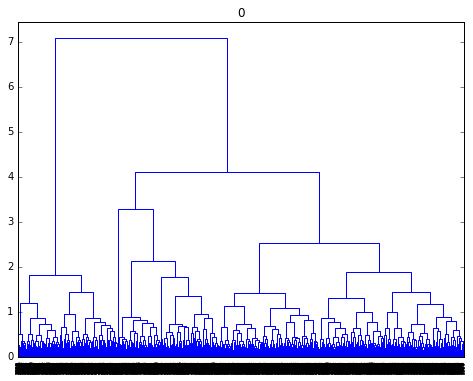

[1 2]
overall =  97.06666666666666
label 1 =  94.13533834586467
label 2 =  97.90149892933619


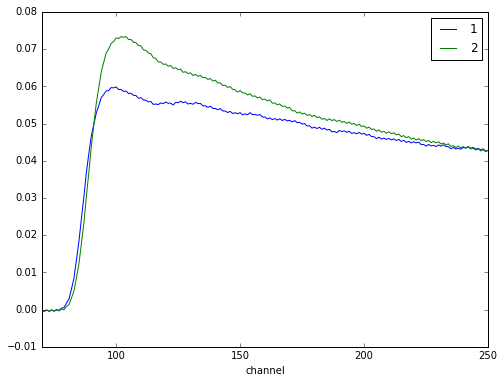

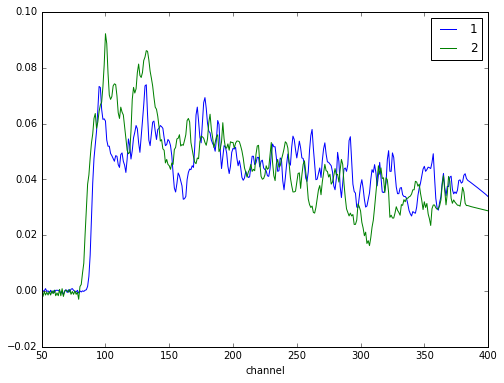

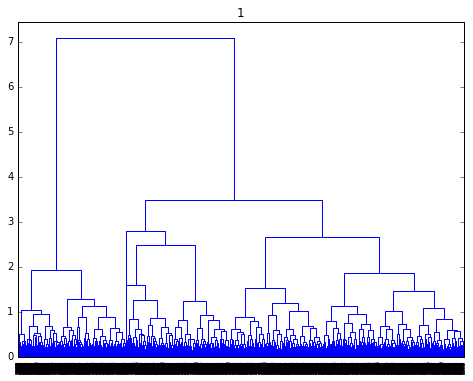

[1 2]
overall =  96.73333333333333
label 1 =  95.25179856115108
label 2 =  97.18004338394793


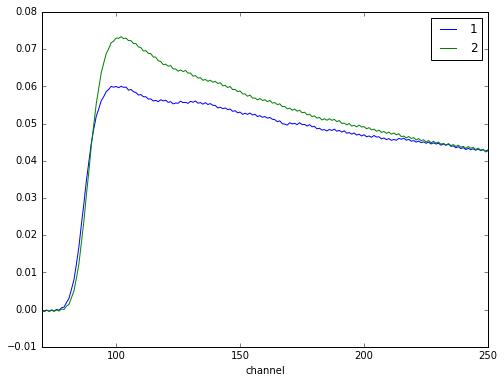

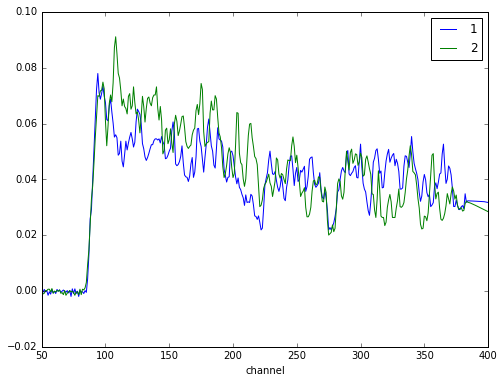

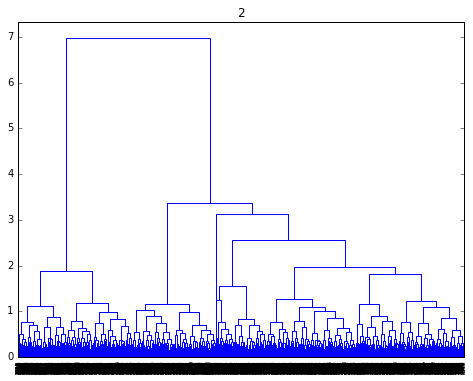

[1 2]
overall =  97.1976401179941
label 1 =  97.70642201834863
label 2 =  97.03595724003887


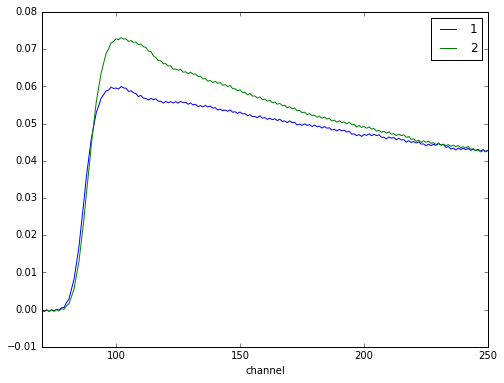

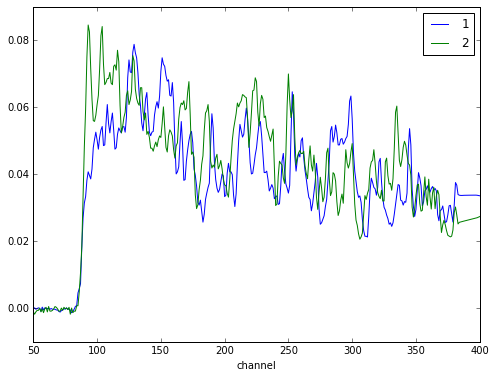

CPU times: user 1min 17s, sys: 9.75 s, total: 1min 26s
Wall time: 1min 22s


In [8]:
%%time
from scipy.cluster import hierarchy

try:
    for batch_number, (waveform, label) in enumerate(data_loader):
        average = []
        average2 = []
        average3 = []
        average4 = []
        average5 = []
#         print(batch_number,label.size())
#         print(waveform.size())
#         if batch_number == 1:
#             break

        batch_size = waveform.size()[0]
#         print(batch_size)
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        feat = GEN(waveform_in)
        features = GEN.encoder(waveform_in)
        
#         print(batch_number)
#         print(feat[0].size())
        
        green = np.reshape(features[0].detach().numpy(),(batch_size,-1))
#         print(green.shape)
        test_x = fc.linkage(green, method="ward")


        Z = linkage(green, method="ward")
#         print(Z.shape)
#         print(Z)
        fig = plt.figure(figsize=(8, 6))
        dn = dendrogram(test_x, count_sort=True, color_threshold=0)
        plt.title(batch_number)
#         plt.savefig("ls.png")
        plt.show()
    
#         dn = dendrogram(Z, color_threshold=0)
#         plt.title(batch_number)
# #         plt.savefig("ls.png")
#         plt.show()
        
#         clusters = fcluster(test_x, 8, depth=10)
# #         print(clusters.shape)
#         print(clusters[:20])
#         print(np.unique(clusters))
              
        iclusters = fcluster(test_x, 2, criterion='maxclust')
#         print(clusters.shape)
#         print(label[:20])
#         print(iclusters[:20])
        print(np.unique(iclusters))
        
#         print(iclusters.shape, label.shape)
        
        label = label.detach().numpy()
        
        correct = np.mean(label == iclusters)
                
        tot = len(label)
        c1 = np.count_nonzero(label==1)
        c2 = np.count_nonzero(label==2)
        
        correct1 = np.zeros(tot)
        correct2 = np.zeros(tot)
        
        for i in range(tot):
            if iclusters[i]==1 and label[i]==1:
                correct1[i] = 1
            if iclusters[i]==2 and label[i]==2:
                correct2[i] = 1
        
        print("overall = ", correct*100)
        print("label 1 = ", np.count_nonzero(correct1==1)/c1*100)
        print("label 2 = ", np.count_nonzero(correct2==1)/c2*100)
#         average = np.append(average,Z)
        
        for i, waveform_out in enumerate(feat[0]):
            
            red = waveform_out.detach().numpy()
#             red = np.reshape(waveform_out.detach().numpy(), (1,-1))
            blue = waveform_in[i].detach().numpy()
#             blue = normalize(waveform_in[i].detach().numpy(),axis=1)

#             print(i, red.shape,blue.shape)
#             print(red[0])
#             print(blue[0])len

#             plt.figure()
#             plt.title("{}".format(clusters[i]))
# #             plt.plot(red[0],label="encoder output",alpha=0.7)
#             plt.plot(blue[0],label="encoder input",alpha=0.7)
#             plt.legend()
# #             plt.savefig("fig/autoencoder{}.png".format(i))
#             plt.show()
    
#             for k in range(len(np.unique(clusters))):
#                 if k==clusters[i]:
#                     plt.figure()
#                     plt.title("{}".format(k))
#                     plt.plot(red[0],label="encoder output",alpha=0.7)
#                     plt.plot(blue[0],label="encoder input",alpha=0.7)
#                     plt.legend()
# #                     plt.savefig("fig/{}_{}.png".format(k,i))
#                     plt.show()

            if iclusters[i]==1:
                average.append(blue[0])
                
            if iclusters[i]==2:
                average2.append(blue[0])
            
#             if clusters[i]==3:
#                 average3.append(blue[0])
                
#             if clusters[i]==4:
#                 average4.append(blue[0])
                
#             if clusters[i]==5:
#                 average5.append(blue[0])
                
        dang = np.mean(average, axis=0)
        dang2 = np.mean(average2, axis=0)
#         dang3 = np.mean(average3, axis=0)
#         dang4 = np.mean(average4, axis=0)
#         dang5 = np.mean(average5, axis=0)
        
        plt.figure(figsize=(8,6))
        plt.plot(dang,label="1")
        plt.plot(dang2,label="2")
#         plt.plot(dang3,label="3")
#         plt.plot(dang4,label="4")
#         plt.plot(dang5,label="5")
        plt.xlim(70,250)
        plt.xlabel("channel")
        plt.legend()
#         plt.title(batch_number)
#         plt.savefig("ls3.png")
        plt.show()
        
        plt.figure(figsize=(8,6))
        plt.plot(average[0], label="1")
        plt.plot(average2[0], label="2")
#         plt.plot(average3[0])
#         plt.plot(average4[0])
        plt.xlim(50,400)
        plt.xlabel("channel")
        plt.legend()
# #         plt.title(batch_number)
# #         plt.savefig("lsr.png")
        plt.show()
        
        
                    
#         Features[batch_number*1000:(batch_number+1)*1000] = feat[0]
        
        
#         print(Features.size())
    # db = DBSCAN(eps=0.3, min_samples=20).fit(DATA.detach().numpy())
    # print(db.core_sample_indices_)
    # print(db.labels_)
        

except KeyboardInterrupt:
    print('Training ended early.')

# +LS

In [53]:
%%time
class Waveform():
    
    def __init__(self, path1=None, path2=None, path3=None):
        if path1 is None:
            raise ValueError("Insert file path!")
        if path2 is None:
            raise ValueError("Insert file path!")
        if path3 is None:
            raise ValueError("Insert file path!")
#         if no_classes is None:
#             raise ValueError("Number of classes?")

        extra = np.arange(4096,4480)

        # type 1
        tree1 = uproot.open(path1)["tree"]
        pmtall1 = tree1.array("PMTALL")
        pmtall1 = np.delete(pmtall1, extra, axis=1)
        pedestal1 = tree1.array("Pedestal")
        pedestal_sum1 = pedestal1[:,0]
        for i in range(len(pedestal_sum1)):
            pmtall1[i] = pedestal_sum1[i] - pmtall1[i]
        
        waveform1 = normalize(pmtall1,axis=1,norm="l2")
        label1 = np.ones(len(pedestal_sum1))*3
        
        del tree1, pmtall1, pedestal1, pedestal_sum1
        
        # type 2
        tree2 = uproot.open(path2)["tree"]
        pmtall2 = tree2.array("PMTALL")
        pmtall2 = np.delete(pmtall2, extra, axis=1)
        pedestal2 = tree2.array("Pedestal")
        pedestal_sum2 = pedestal2[:,0]
        for i in range(len(pedestal_sum2)):
            pmtall2[i] = pedestal_sum2[i] - pmtall2[i]
            
        waveform2 = normalize(pmtall2,axis=1,norm="l2")
        label2 = np.ones(len(pedestal_sum2))*2
        
        del tree2, pmtall2, pedestal2, pedestal_sum2
        
        # type 3
        tree3 = uproot.open(path3)["tree"]
        pmtall3 = tree3.array("PMTALL")
        pmtall3 = np.delete(pmtall3, extra, axis=1)
        pedestal3 = tree3.array("Pedestal")
        pedestal_sum3 = pedestal3[:,0]
        for i in range(len(pedestal_sum3)):
            pmtall3[i] = pedestal_sum3[i] - pmtall3[i]
            
        waveform3 = normalize(pmtall3,axis=1,norm="l2")
        label3 = np.ones(len(pedestal_sum3))
        
        del tree3, pmtall3, pedestal3, pedestal_sum3
        
        self.waveform = np.concatenate((waveform1, 
                                        waveform2,
                                        waveform3),axis=0)
        self.label = np.concatenate((label1, 
                                     label2, 
                                     label3),axis=0)
        
        del waveform1, waveform2, waveform3, label1, label2, label3
    
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx], self.label[idx]

CPU times: user 31 µs, sys: 0 ns, total: 31 µs
Wall time: 36.7 µs


In [54]:
dataset = Waveform(path1="Alpha.root", path2="RefPulse009.root", 
                   path3="LS.root")

BATCH_SIZE = 3000

data_loader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=3) 

In [55]:
n_batches = int(len(dataset)/BATCH_SIZE)
print(len(dataset))
print(n_batches)
del dataset

25564
8


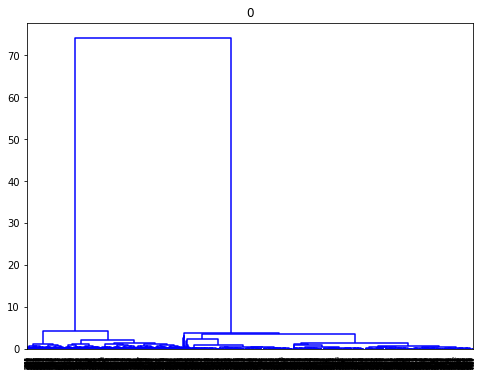

[1 2 3]
overall =  99.36666666666667
label 1 =  100.0
label 2 =  99.1701244813278
label 3 =  97.90897908979089


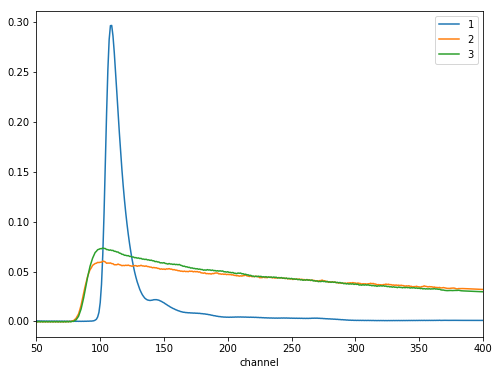

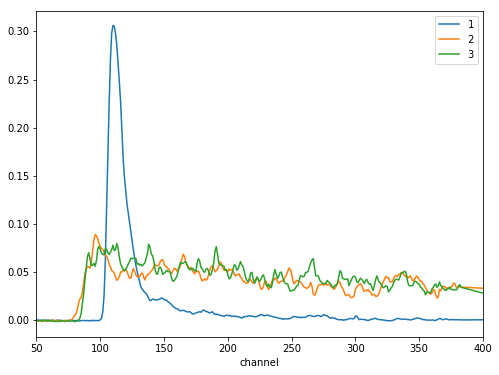

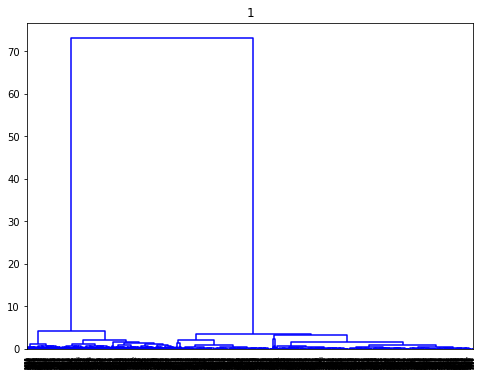

[1 2 3]
overall =  98.96666666666667
label 1 =  100.0
label 2 =  96.80365296803653
label 3 =  96.92307692307692


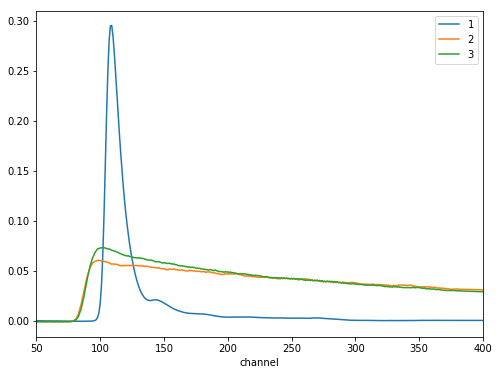

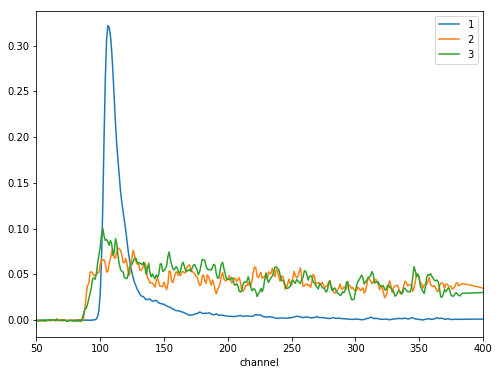

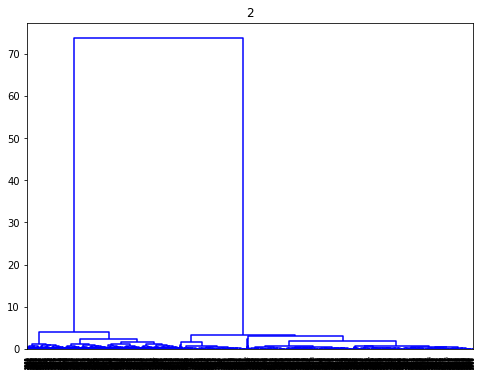

[1 2 3]
overall =  98.5
label 1 =  100.0
label 2 =  93.64406779661016
label 3 =  96.20253164556962


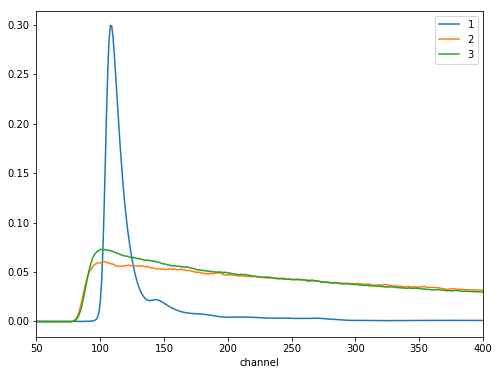

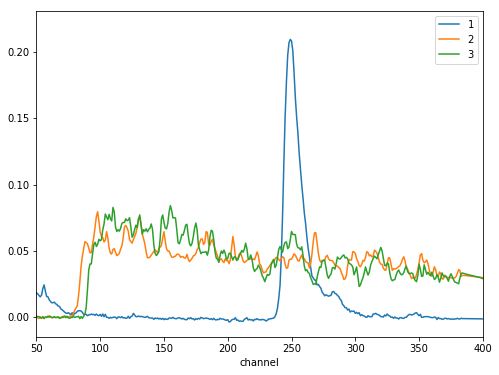

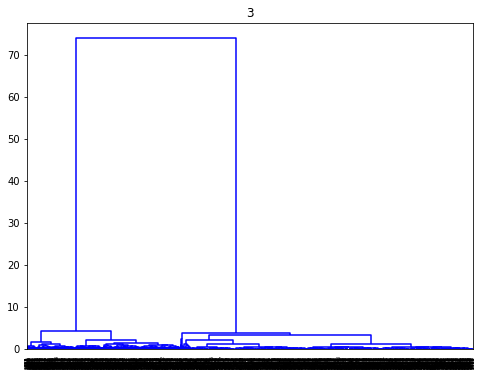

[1 2 3]
overall =  98.2
label 1 =  100.0
label 2 =  98.55072463768117
label 3 =  93.39498018494055


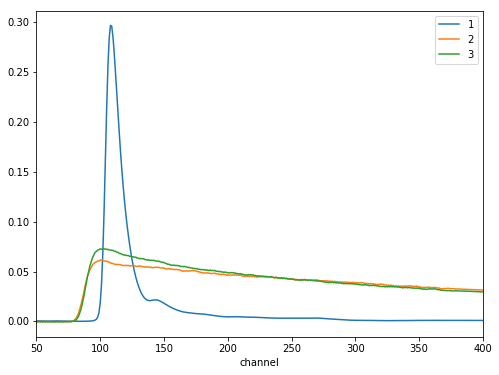

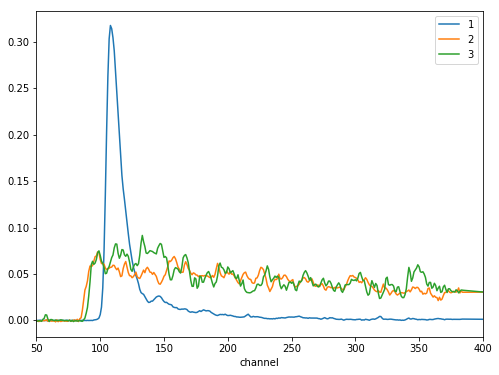

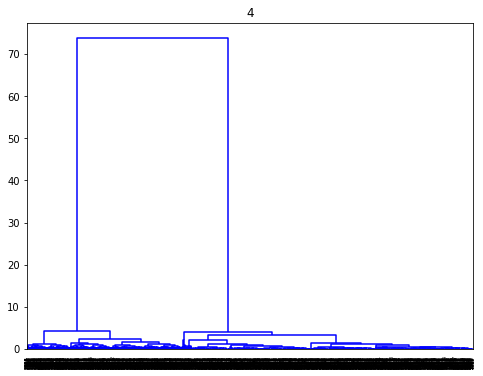

[1 2 3]
overall =  98.43333333333332
label 1 =  100.0
label 2 =  98.80952380952381
label 3 =  94.44444444444444


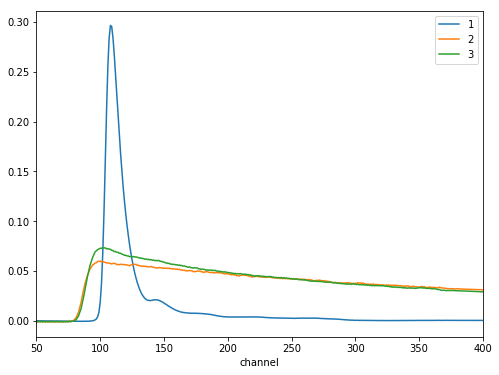

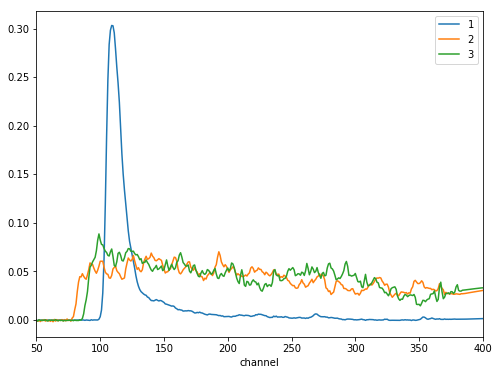

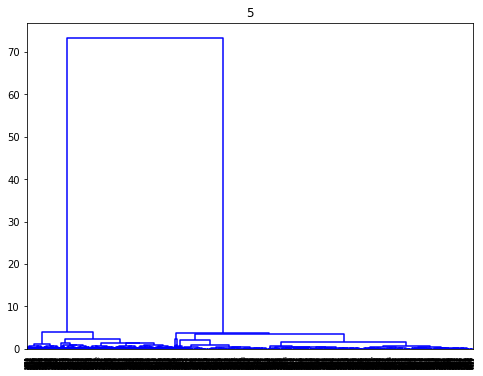

[1 2 3]
overall =  99.33333333333333
label 1 =  100.0
label 2 =  94.39655172413794
label 3 =  99.08256880733946


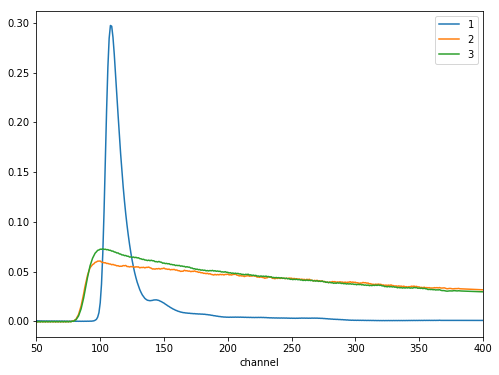

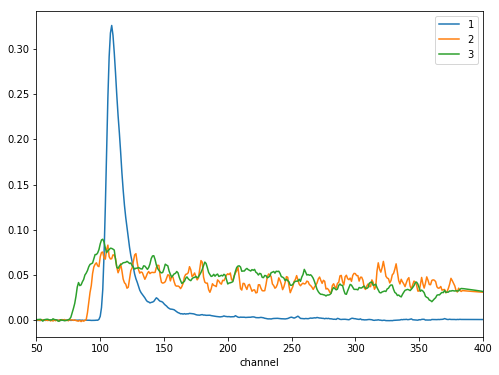

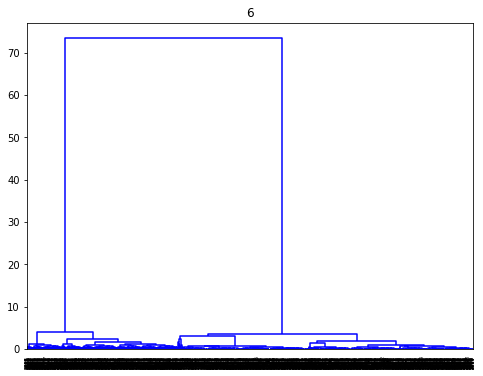

[1 2 3]
overall =  98.96666666666667
label 1 =  100.0
label 2 =  96.80365296803653
label 3 =  96.99624530663328


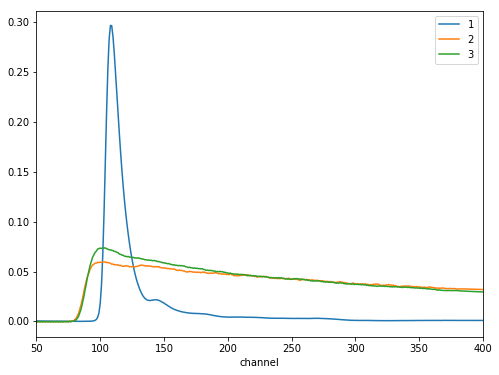

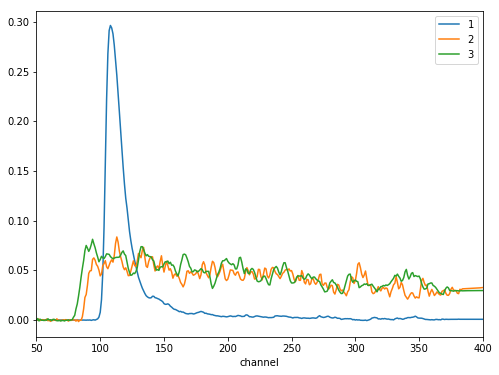

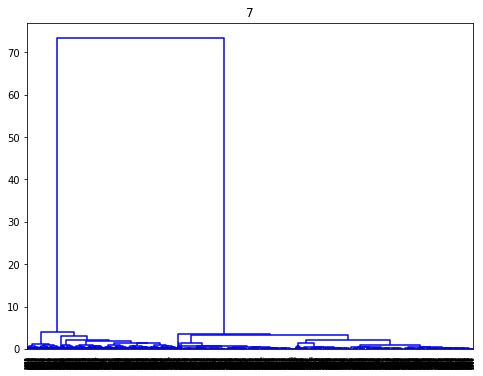

[1 2 3]
overall =  98.8
label 1 =  100.0
label 2 =  95.67307692307693
label 3 =  96.64179104477611


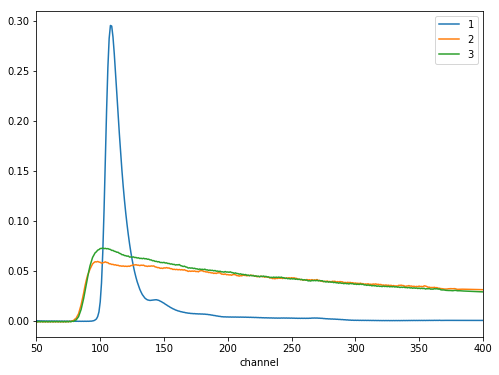

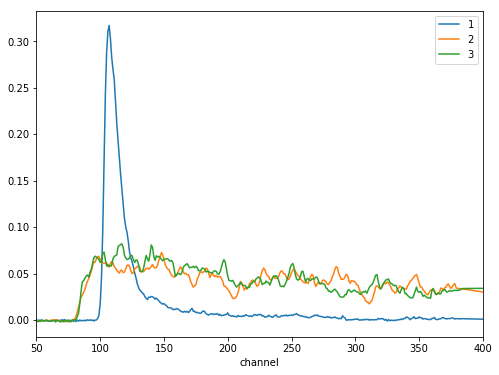

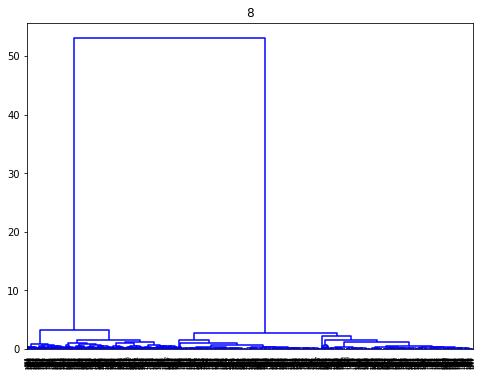

[1 2 3]
overall =  99.48849104859335
label 1 =  100.0
label 2 =  98.47328244274809
label 3 =  98.5


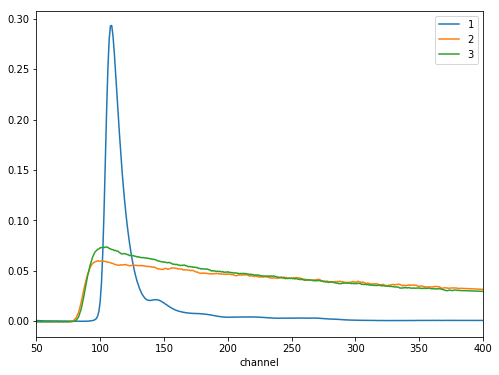

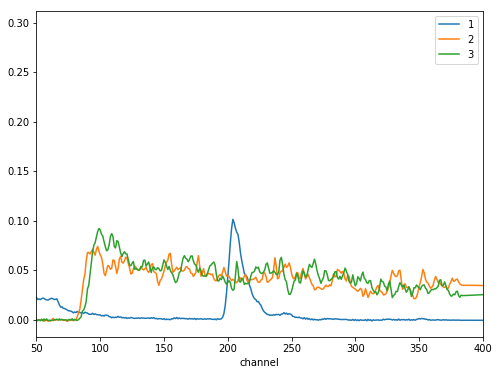

CPU times: user 1min 51s, sys: 15.2 s, total: 2min 6s
Wall time: 1min 34s


In [57]:
%%time
from scipy.cluster import hierarchy

try:
    for batch_number, (waveform, label) in enumerate(data_loader):
        average = []
        average2 = []
        average3 = []
        average4 = []
        average5 = []
#         print(batch_number,label.size())
#         print(waveform.size())
#         if batch_number == 10:
#             break

        batch_size = waveform.size()[0]
#         print(batch_size)
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        feat = GEN(waveform_in)
        features = GEN.encoder(waveform_in)
        
#         print(batch_number)
#         print(feat[0].size())
        
        green = np.reshape(features[0].detach().numpy(),(batch_size,-1))
#         print(green.shape)
        test_x = fc.linkage(green, method="ward")


        Z = linkage(green, method="ward")
#         print(Z.shape)
#         print(Z)
        fig = plt.figure(figsize=(8,6))
        dn = dendrogram(test_x, count_sort=True, color_threshold=0)
        plt.title(batch_number)
#         plt.savefig("ls.png")
        plt.show()
    
#         dn = dendrogram(Z, color_threshold=0)
#         plt.title(batch_number)
# #         plt.savefig("ls.png")
#         plt.show()
        
#         clusters = fcluster(test_x, 8, depth=10)
# #         print(clusters.shape)
#         print(clusters[:20])
#         print(np.unique(clusters))
              
        iclusters = fcluster(test_x, 3, criterion='maxclust')
#         print(clusters.shape)
#         print(label[:20])
#         print(iclusters[:20])
        print(np.unique(iclusters))
        
        label = label.detach().numpy()
        
        correct = np.mean(label == iclusters)
                
        tot = len(label)
        c1 = np.count_nonzero(label==1)
        c2 = np.count_nonzero(label==2)
        c3 = np.count_nonzero(label==3)
        
        correct1 = np.zeros(tot)
        correct2 = np.zeros(tot)
        correct3 = np.zeros(tot)
        
        for i in range(tot):
            if iclusters[i]==1 and label[i]==1:
                correct1[i] = 1
            if iclusters[i]==2 and label[i]==2:
                correct2[i] = 1
            if iclusters[i]==3 and label[i]==3:
                correct3[i] = 1
        
        print("overall = ", correct*100)
        print("label 1 = ", np.count_nonzero(correct1==1)/c1*100)
        print("label 2 = ", np.count_nonzero(correct2==1)/c2*100)
        print("label 3 = ", np.count_nonzero(correct3==1)/c3*100)
        
#         average = np.append(average,Z)
        
        for i, waveform_out in enumerate(feat[0]):
            
            red = waveform_out.detach().numpy()
#             red = np.reshape(waveform_out.detach().numpy(), (1,-1))
            blue = waveform_in[i].detach().numpy()
#             blue = normalize(waveform_in[i].detach().numpy(),axis=1)

#             print(i, red.shape,blue.shape)
#             print(red[0])
#             print(blue[0])

#             plt.figure()
#             plt.title("{}".format(clusters[i]))
# #             plt.plot(red[0],label="encoder output",alpha=0.7)
#             plt.plot(blue[0],label="encoder input",alpha=0.7)
#             plt.legend()
# #             plt.savefig("fig/autoencoder{}.png".format(i))
#             plt.show()
    
#             for k in range(len(np.unique(clusters))):
#                 if k==clusters[i]:
#                     plt.figure()
#                     plt.title("{}".format(k))
#                     plt.plot(red[0],label="encoder output",alpha=0.7)
#                     plt.plot(blue[0],label="encoder input",alpha=0.7)
#                     plt.legend()
# #                     plt.savefig("fig/{}_{}.png".format(k,i))
#                     plt.show()

            if iclusters[i]==1:
                average.append(blue[0])
                
            if iclusters[i]==2:
                average2.append(blue[0])
            
            if iclusters[i]==3:
                average3.append(blue[0])
                
#             if clusters[i]==4:
#                 average4.append(blue[0])
                
#             if clusters[i]==5:
#                 average5.append(blue[0])
                
        dang = np.mean(average, axis=0)
        dang2 = np.mean(average2, axis=0)
        dang3 = np.mean(average3, axis=0)
#         dang4 = np.mean(average4, axis=0)
#         dang5 = np.mean(average5, axis=0)
        
        plt.figure(figsize=(8,6))
        plt.plot(dang,label="1")
        plt.plot(dang2,label="2")
        plt.plot(dang3,label="3")
#         plt.plot(dang4,label="4")
#         plt.plot(dang5,label="5")
        plt.xlim(50,400)
        plt.xlabel("channel")
        plt.legend()
#         plt.title(batch_number)
#         plt.savefig("ls3.png")
        plt.show()
        
        plt.figure(figsize=(8,6))
        plt.plot(average[0], label="1")
        plt.plot(average2[0], label="2")
        plt.plot(average3[0], label="3")
#         plt.plot(average4[0])
        plt.xlim(50,400)
        plt.xlabel("channel")
        plt.legend()
# #         plt.title(batch_number)
# #         plt.savefig("lsr.png")
        plt.show()
        
        
                    
#         Features[batch_number*1000:(batch_number+1)*1000] = feat[0]
        
        
#         print(Features.size())
    # db = DBSCAN(eps=0.3, min_samples=20).fit(DATA.detach().numpy())
    # print(db.core_sample_indices_)
    # print(db.labels_)
        

except KeyboardInterrupt:
    print('Training ended early.')

# + Custom double pulse

In [17]:
%%time
class Waveform():
    
    def __init__(self, path1=None, path2=None, path3=None, path4=None):
        if path1 is None:
            raise ValueError("Insert file path!")
        if path2 is None:
            raise ValueError("Insert file path!")
        if path3 is None:
            raise ValueError("Insert file path!")
        if path4 is None:
            raise ValueError("Insert file path!")
#         if no_classes is None:
#             raise ValueError("Number of classes?")

        extra = np.arange(4096,4480)

        # type 1
        tree1 = uproot.open(path1)["tree"]
        pmtall1 = tree1.array("PMTALL")
        pmtall1 = np.delete(pmtall1, extra, axis=1)
        pedestal1 = tree1.array("Pedestal")
        pedestal_sum1 = pedestal1[:,0]
        for i in range(len(pedestal_sum1)):
            pmtall1[i] = pedestal_sum1[i] - pmtall1[i]
        
        waveform1 = normalize(pmtall1,axis=1,norm="l2")
        label1 = np.ones(len(pedestal_sum1))*2
        
        del tree1, pmtall1, pedestal1, pedestal_sum1
        
        # type 2
        tree2 = uproot.open(path2)["tree"]
        pmtall2 = tree2.array("PMTALL")
        pmtall2 = np.delete(pmtall2, extra, axis=1)
        pedestal2 = tree2.array("Pedestal")
        pedestal_sum2 = pedestal2[:,0]
        for i in range(len(pedestal_sum2)):
            pmtall2[i] = pedestal_sum2[i] - pmtall2[i]
            
        waveform2 = normalize(pmtall2,axis=1,norm="l2")
        label2 = np.ones(len(pedestal_sum2))*2
        
        del tree2, pmtall2, pedestal2, pedestal_sum2
        
        # type 3
        tree3 = uproot.open(path3)["tree"]
        pmtall3 = tree3.array("PMTALL")
        pmtall3 = np.delete(pmtall3, extra, axis=1)
        pedestal3 = tree3.array("Pedestal")
        pedestal_sum3 = pedestal3[:,0]
        for i in range(len(pedestal_sum3)):
            pmtall3[i] = pedestal_sum3[i] - pmtall3[i]
            
        waveform3 = normalize(pmtall3,axis=1,norm="l2")
        label3 = np.ones(len(pedestal_sum3))
        
        del tree3, pmtall3, pedestal3, pedestal_sum3
        
        # type 4
        tree4 = uproot.open(path4)["tree"]
        pmtall4 = tree4.array("PMTALL")
        pmtall4 = np.delete(pmtall4, extra, axis=1)
        pedestal4 = tree4.array("Pedestal")
        pedestal_sum4 = pedestal4[:,0]
        for i in range(len(pedestal_sum4)):
            pmtall4[i] = pedestal_sum4[i] - pmtall4[i]
            
        waveform4 = normalize(pmtall4,axis=1,norm="l2")
        label4 = np.ones(len(pedestal_sum4))*3
        
        del tree4, pmtall4, pedestal4, pedestal_sum4
        
        self.waveform = np.concatenate((waveform1, 
                                        waveform2,
                                        waveform3[:5000], 
                                        waveform4),axis=0)
        self.label = np.concatenate((label1, 
                                     label2, 
                                     label3[:5000], 
                                     label4),axis=0)
        
        del waveform1, waveform2, waveform3, waveform4
        del label1, label2, label3, label4
    
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx], self.label[idx]

CPU times: user 28 µs, sys: 0 ns, total: 28 µs
Wall time: 31.2 µs


In [30]:
dataset = Waveform(path1="Alpha.root", path2="RefPulse009.root", 
                   path3="LS.root",path4="Piled_2.root")

BATCH_SIZE = 2000

data_loader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=3) 

In [31]:
n_batches = int(len(dataset)/BATCH_SIZE)
print(len(dataset))
print(n_batches)
del dataset

15785
7


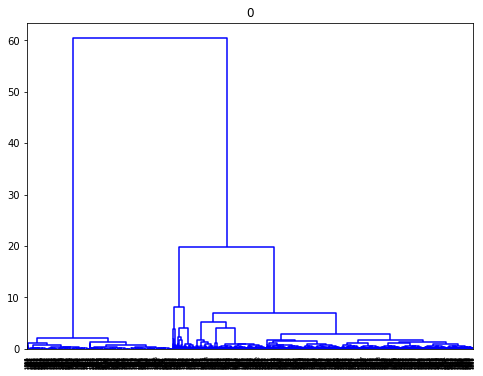

[1 2 3 4]
overall =  88.9
label 1 =  100.0
label 2 =  100.0
label 3 =  42.38683127572017


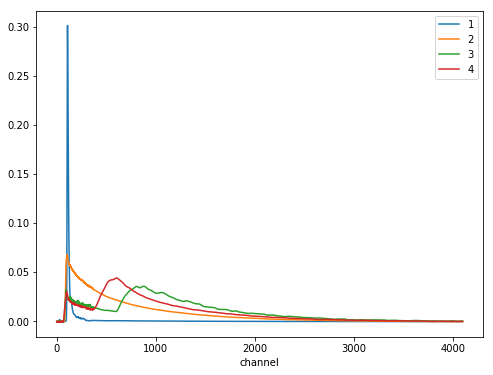

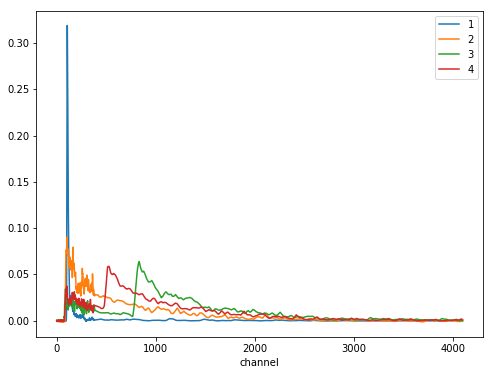

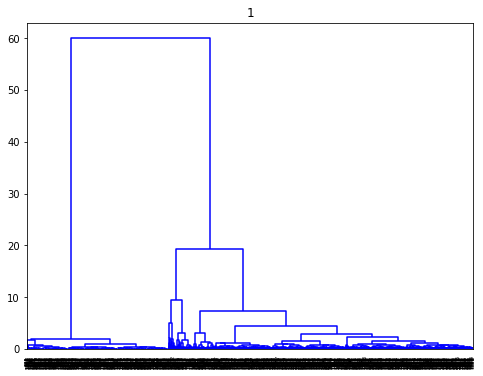

[1 2 3 4]
overall =  90.60000000000001
label 1 =  100.0
label 2 =  100.0
label 3 =  41.66666666666667


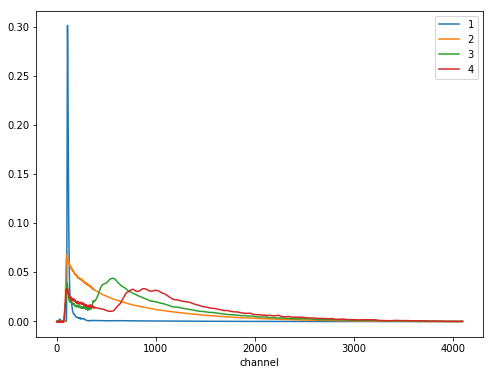

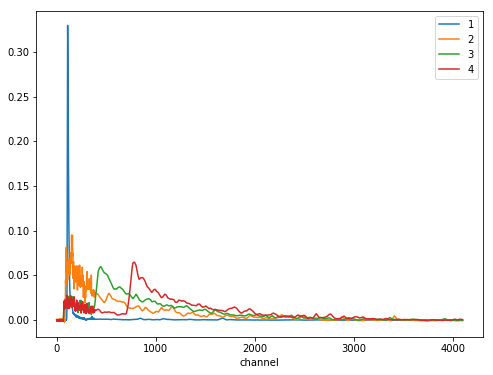

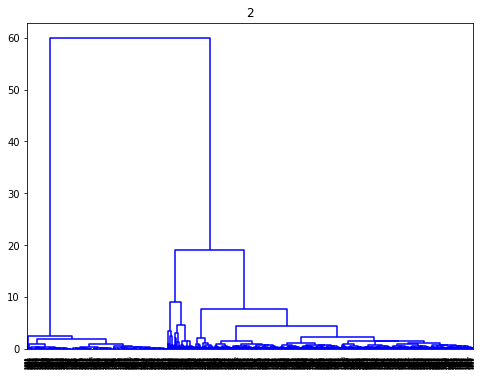

[1 2 3 4]
overall =  88.64999999999999
label 1 =  100.0
label 2 =  100.0
label 3 =  47.286821705426355


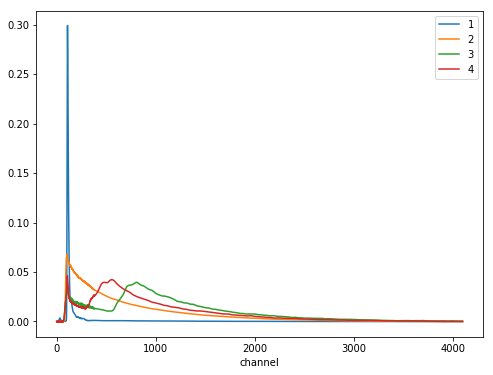

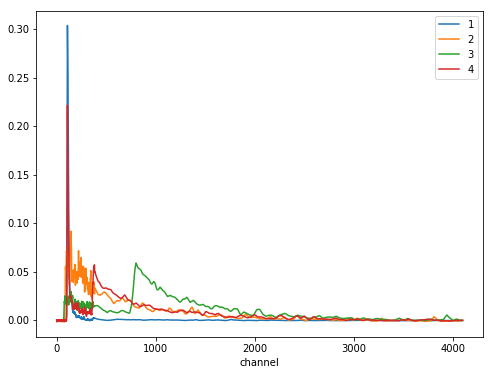

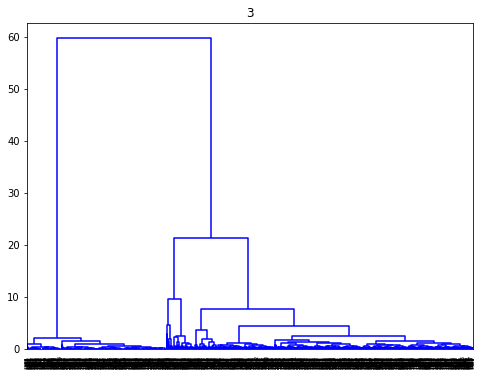

[1 2 3 4]
overall =  91.10000000000001
label 1 =  100.0
label 2 =  99.909338168631
label 3 =  46.125461254612546


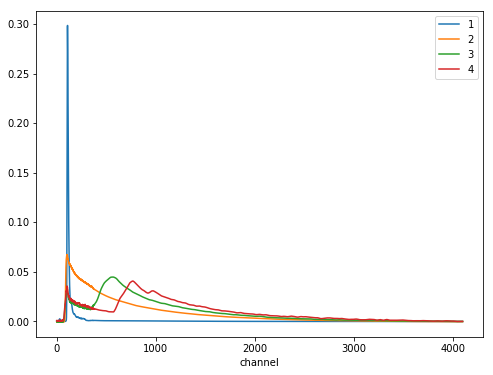

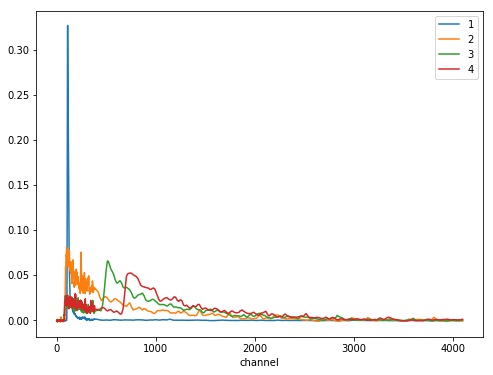

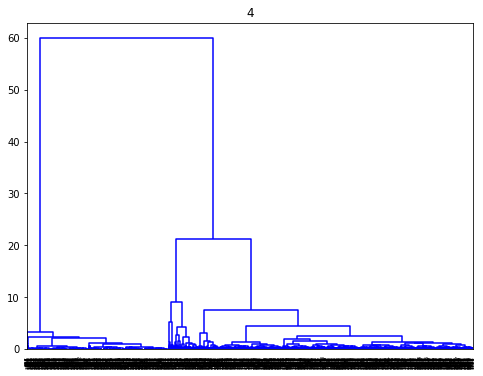

[1 2 3 4]
overall =  92.10000000000001
label 1 =  100.0
label 2 =  99.90925589836661
label 3 =  50.950570342205324


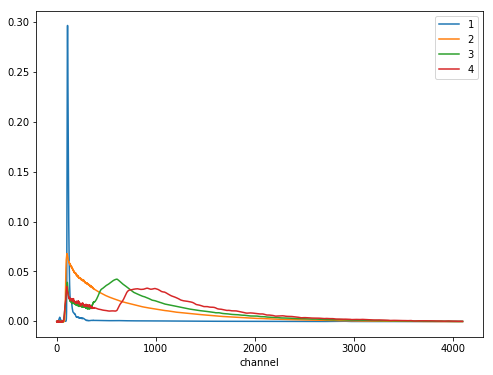

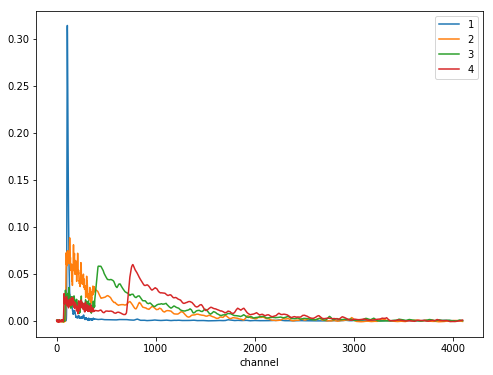

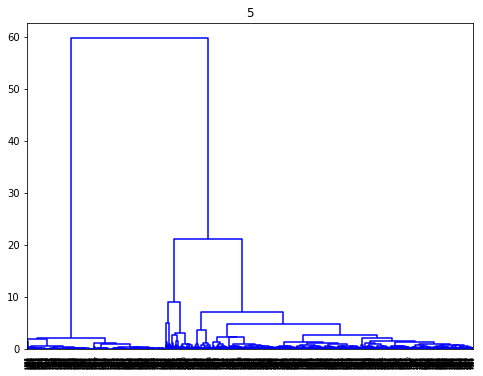

[1 2 3 4]
overall =  91.14999999999999
label 1 =  100.0
label 2 =  100.0
label 3 =  45.55160142348754


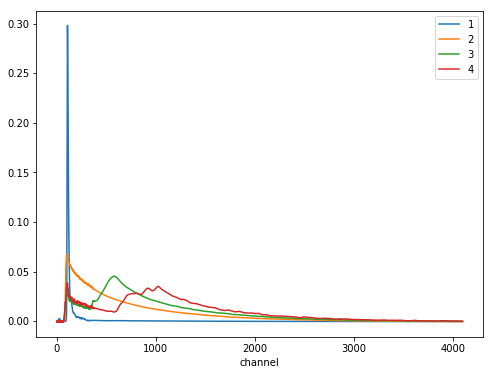

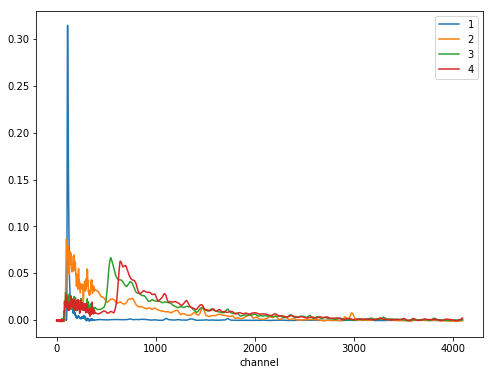

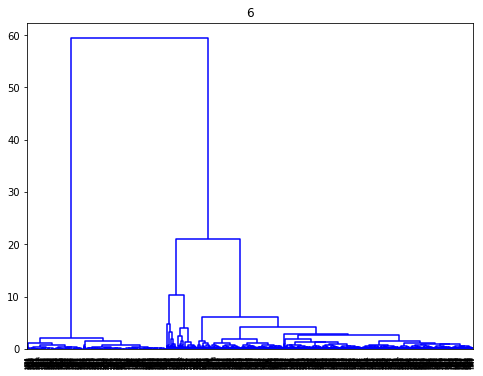

[1 2 3 4]
overall =  92.30000000000001
label 1 =  100.0
label 2 =  100.0
label 3 =  56.50406504065041


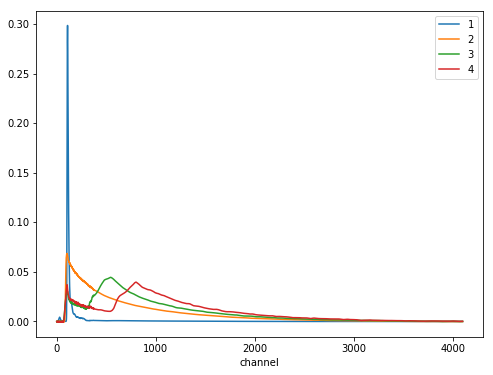

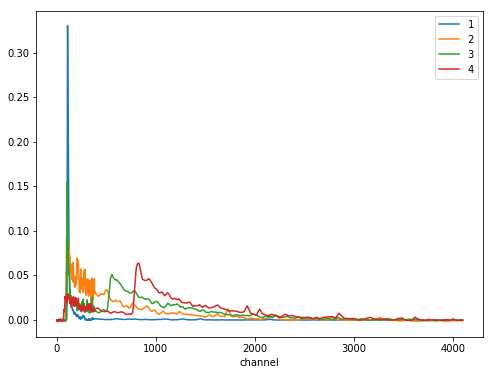

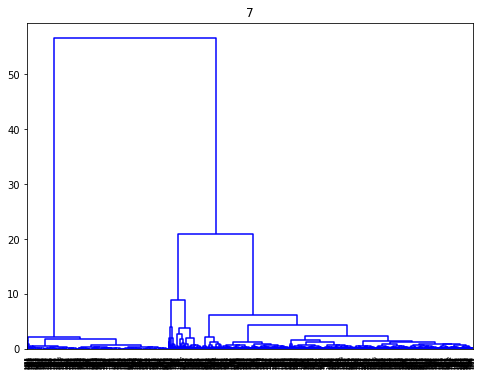

[1 2 3 4]
overall =  92.04481792717087
label 1 =  100.0
label 2 =  100.0
label 3 =  54.655870445344135


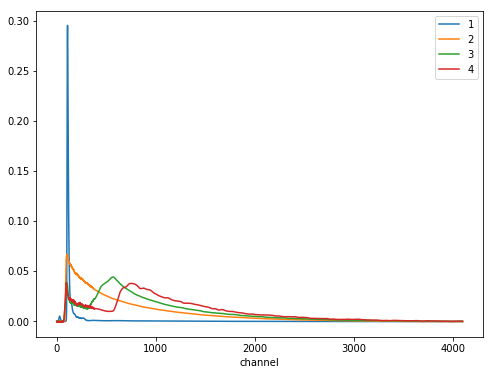

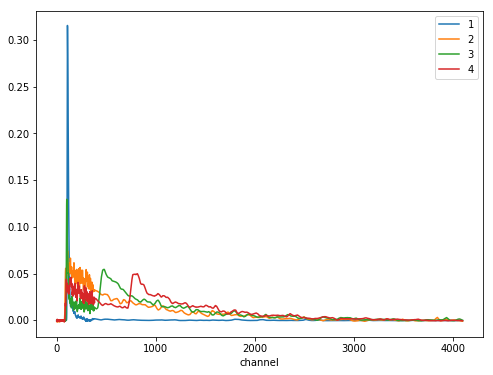

CPU times: user 1min 6s, sys: 10.9 s, total: 1min 17s
Wall time: 54.7 s


In [32]:
%%time
from scipy.cluster import hierarchy

try:
    for batch_number, (waveform, label) in enumerate(data_loader):
        average = []
        average2 = []
        average3 = []
        average4 = []
        average5 = []
#         print(batch_number,label.size())
#         print(waveform.size())
#         if batch_number == 10:
#             break

        batch_size = waveform.size()[0]
#         print(batch_size)
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        feat = GEN(waveform_in)
        features = GEN.encoder(waveform_in)
        
#         print(batch_number)
#         print(feat[0].size())
        
        green = np.reshape(features[0].detach().numpy(),(batch_size,-1))
#         print(green.shape)
        test_x = fc.linkage(green, method="ward")


        Z = linkage(green, method="ward")
#         print(Z.shape)
#         print(Z)
        fig = plt.figure(figsize=(8,6))
        dn = dendrogram(test_x, count_sort=True, color_threshold=0)
        plt.title(batch_number)
#         plt.savefig("ls.png")
        plt.show()
    
#         dn = dendrogram(Z, color_threshold=0)
#         plt.title(batch_number)
# #         plt.savefig("ls.png")
#         plt.show()
        
#         clusters = fcluster(test_x, 8, depth=10)
# #         print(clusters.shape)
#         print(clusters[:20])
#         print(np.unique(clusters))
              
        iclusters = fcluster(test_x, 4, criterion='maxclust')
#         print(clusters.shape)
#         print(label[:20])
#         print(iclusters[:20])
        print(np.unique(iclusters))
        
        label = label.detach().numpy()
        
        correct = np.mean(label == iclusters)
                
        tot = len(label)
        c1 = np.count_nonzero(label==1)
        c2 = np.count_nonzero(label==2)
        c3 = np.count_nonzero(label==3)
        c4 = np.count_nonzero(label==4)
        
        correct1 = np.zeros(tot)
        correct2 = np.zeros(tot)
        correct3 = np.zeros(tot)
#         correct4 = np.zeros(tot)
        
        for i in range(tot):
            if iclusters[i]==1 and label[i]==1:
                correct1[i] = 1
            if iclusters[i]==2 and label[i]==2:
                correct2[i] = 1
            if (iclusters[i]==3 and label[i]==3)or(iclusters[i]==4 and label[i]==3):
                correct3[i] = 1
#             if iclusters[i]==4 and label[i]==4:
#                 correct4[i] = 1
        
        print("overall = ", correct*100)
        print("label 1 = ", np.count_nonzero(correct1==1)/c1*100)
        print("label 2 = ", np.count_nonzero(correct2==1)/c2*100)
        print("label 3 = ", np.count_nonzero(correct3==1)/(c3+c4)*100)
#         print("label 4 = ", np.count_nonzero(correct4==1)/c4*100)
        
#         average = np.append(average,Z)
        
        for i, waveform_out in enumerate(feat[0]):
            
            red = waveform_out.detach().numpy()
#             red = np.reshape(waveform_out.detach().numpy(), (1,-1))
            blue = waveform_in[i].detach().numpy()
#             blue = normalize(waveform_in[i].detach().numpy(),axis=1)

#             print(i, red.shape,blue.shape)
#             print(red[0])
#             print(blue[0])

#             plt.figure()
#             plt.title("{}".format(clusters[i]))
# #             plt.plot(red[0],label="encoder output",alpha=0.7)
#             plt.plot(blue[0],label="encoder input",alpha=0.7)
#             plt.legend()
# #             plt.savefig("fig/autoencoder{}.png".format(i))
#             plt.show()
    
#             for k in range(len(np.unique(clusters))):
#                 if k==clusters[i]:
#                     plt.figure()
#                     plt.title("{}".format(k))
#                     plt.plot(red[0],label="encoder output",alpha=0.7)
#                     plt.plot(blue[0],label="encoder input",alpha=0.7)
#                     plt.legend()
# #                     plt.savefig("fig/{}_{}.png".format(k,i))
#                     plt.show()

            if iclusters[i]==1:
                average.append(blue[0])
                
            if iclusters[i]==2:
                average2.append(blue[0])
            
            if iclusters[i]==3:
                average3.append(blue[0])
                
            if iclusters[i]==4:
                average4.append(blue[0])
                
#             if clusters[i]==5:
#                 average5.append(blue[0])
                
        dang = np.mean(average, axis=0)
        dang2 = np.mean(average2, axis=0)
        dang3 = np.mean(average3, axis=0)
        dang4 = np.mean(average4, axis=0)
#         dang5 = np.mean(average5, axis=0)
        
        plt.figure(figsize=(8,6))
        plt.plot(dang,label="1")
        plt.plot(dang2,label="2")
        plt.plot(dang3,label="3")
        plt.plot(dang4,label="4")
#         plt.plot(dang5,label="5")
#         plt.xlim(50,400)
        plt.xlabel("channel")
        plt.legend()
#         plt.title(batch_number)
#         plt.savefig("ls3.png")
        plt.show()
        
        plt.figure(figsize=(8,6))
        plt.plot(average[0], label="1")
        plt.plot(average2[0], label="2")
        plt.plot(average3[0], label="3")
        plt.plot(average4[0], label="4")
#         plt.xlim(50,400)
        plt.xlabel("channel")
        plt.legend()
# #         plt.title(batch_number)
# #         plt.savefig("lsr.png")
        plt.show()
        
        
                    
#         Features[batch_number*1000:(batch_number+1)*1000] = feat[0]
        
        
#         print(Features.size())
    # db = DBSCAN(eps=0.3, min_samples=20).fit(DATA.detach().numpy())
    # print(db.core_sample_indices_)
    # print(db.labels_)
        

except KeyboardInterrupt:
    print('Training ended early.')